### aim: convert observational regridded T and S fields (given in observational T,S units) to model T and S fields

The World Ocean Atlas temperature and salinity data are given as in-situ (T) (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NCEI-WOA18)
and psu (S), while NEMO uses Conservative Temperature and Absolute Salinity (~reference salinity) as state values. 

for in-depth temperature and salinity discussion see:
https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293/

the conversion from psu to reference salinity is simple:
https://tos.org/oceanography/article/history-of-the-equation-of-state-of-seawater
SR = SP (35.16504/35.000) g kg–1 where SP is psu. 

The conversion from in-situ T and conservative T is slightly more involved and requires absolute salinity and sea pressure:

https://teos-10.github.io/GSW-Python/gsw_flat.html

https://teos-10.github.io/GSW-Python/_modules/gsw/_wrapped_ufuncs.html#CT_from_t

https://www.teos-10.org/pubs/gsw/html/gsw_pt_from_t.html

### date: 2023-05-30 

In [143]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [144]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [145]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import gsw
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## Demonstrating difference between in situ t and potential temperature/conservative temperature, which becomes pronounced at depth (potential t and conservative t are roughly similar)

Help on function pt0_from_t in module gsw._wrapped_ufuncs:

pt0_from_t(SA, t, p)
    Calculates potential temperature with reference pressure, p_ref = 0 dbar.
    The present routine is computationally faster than the more general
    function "gsw_pt_from_t(SA,t,p,p_ref)" which can be used for any
    reference pressure value.
    This subroutine calls "gsw_entropy_part(SA,t,p)",
    "gsw_entropy_part_zerop(SA,pt0)" and "gsw_gibbs_pt0_pt0(SA,pt0)".
    
    Parameters
    ----------
    SA : array-like
        Absolute Salinity, g/kg
    t : array-like
        In-situ temperature (ITS-90), degrees C
    p : array-like
        Sea pressure (absolute pressure minus 10.1325 dbar), dbar
    
    Returns
    -------
    pt0 : array-like, deg C
        potential temperature
        with reference sea pressure (p_ref) = 0 dbar.



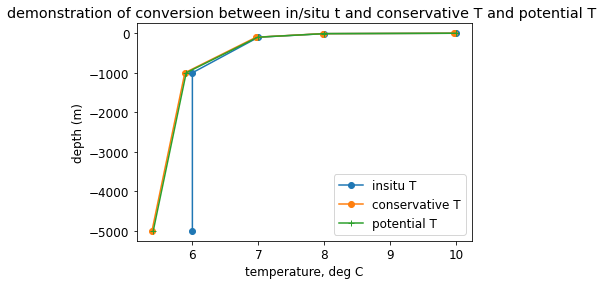

In [146]:
help(gsw.pt0_from_t)
depth = np.array([0,10,100,1000,5000]) #pressure in dbar is basically depth in m
pres = depth 
insituT = np.array([10,8,7,6,6])
absS = np.array([36.2,36.2,36.2,36.2,36.2])
consT = gsw.CT_from_t(absS,insituT,pres)
potT = gsw.pt0_from_t(absS,insituT,pres)


plt.figure()
plt.plot(insituT,-depth, label = 'insitu T', marker = 'o')
plt.plot(consT, -depth,  label = 'conservative T', marker = 'o')
plt.plot(potT, -depth,  label = 'potential T', linestyle = '-', marker = '+')
plt.xlabel('temperature, deg C')
plt.ylabel('depth (m)')
plt.title('demonstration of conversion between in/situ t and conservative T and potential T ')
plt.legend()

## unit conversions in t and s files

##### original WOA files downloaded

The original downloaded files can be found here - /gpfs/home/avd22gnu/scratch/WOA


 

##### regridded PT files

The regridded temperature and salinity files for each decade can be found here - /gpfs/home/avd22gnu/scratch/WOA/scripts/regrid, of the form woa18_<decade>_<s/t>00_01_regridORCA.nc. There are six decades in total.

 

In [147]:
print('names of WOA original file T and S')
woa_orig_file_t = xr.open_dataset('/gpfs/home/avd22gnu/scratch/WOA/temperature/decav/woa18_decav_t00_01.nc', decode_times=False)
print(woa_orig_file_t.t_an.long_name)
woa_orig_file_s = xr.open_dataset('/gpfs/home/avd22gnu/scratch/WOA/salinity/decav/woa18_decav_s00_01.nc', decode_times=False)
print(woa_orig_file_s.s_an.long_name)



names of WOA original file T and S
Objectively analyzed mean fields for sea_water_temperature at standard depth levels.
Objectively analyzed mean fields for sea_water_salinity at standard depth levels.


In [148]:
print('names of TOM output')
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_20310101_20311231_grid_T.nc')
print(w.vosaline.long_name)
print(w.vosaline.standard_name)
print()
print(w.votemper.long_name)
print(w.votemper.standard_name)
print('note we are using TEOS-10 according to nn_eos, which means we actually calculate abs salinity and cons. temp. ')

names of TOM output
salinity
sea_water_practical_salinity

temperature
sea_water_potential_temperature
note we are using TEOS-10 according to nn_eos, which means we actually calculate abs salinity and cons. temp. 


<Figure size 432x288 with 0 Axes>

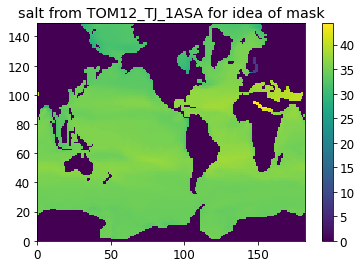

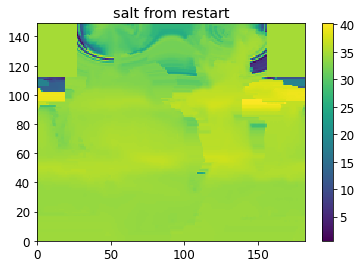

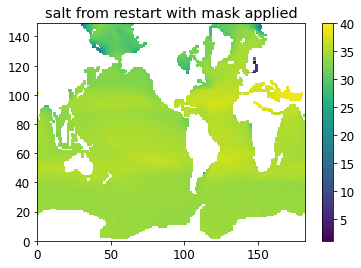

<Figure size 432x288 with 0 Axes>

In [149]:
tdir_regrid = '/gpfs/home/avd22gnu/scratch/WOA/scripts/regrid/'

dec = '6574'
salt = xr.open_dataset(f'{tdir_regrid}woa18_{dec}_s00_01_regridORCA.nc', decode_times = False)
temp = xr.open_dataset(f'{tdir_regrid}woa18_{dec}_t00_01_regridORCA.nc', decode_times = False)


plt.figure()
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_20310101_20311231_grid_T.nc')
w.vosaline
v = plt.pcolormesh(w['vosaline'][0,0,:,:])
plt.colorbar(v)
mod_salt = w['vosaline'][0,0,:,:].values
plt.title('salt from TOM12_TJ_1ASA for idea of mask')

plt.figure()
w = plt.pcolormesh(salt['s_an'][0,0,:,:])
plt.colorbar(w)
plt.title('salt from restart')

salt_regridded = salt['s_an'][0,0,:,:].values
salt_regridded_mask = np.copy(salt_regridded)
salt_regridded_mask[mod_salt == 0] = np.nan
plt.figure()
w = plt.pcolormesh(salt_regridded_mask)
plt.colorbar(w)
plt.title('salt from restart with mask applied')

plt.figure()




## salinity adjustment code

simple adjustment
 SR = SP (35.16504/35.000) g kg–1 where SP is psu, sr is reference salinity
 
 I just make a deep copy of the original variable, call it s_an_gkg, and then replace the values with the simple adjustment. 
 
 I visualize the difference to make sure it gives reasonable numbers. 

I then save a new file to `/gpfs/home/mep22dku/scratch/WOA_regrid_TS` with the suffix `unitconv`.

Text(0.5, 1.0, 'original (psu) - new (g/kg) \n decade 5564')

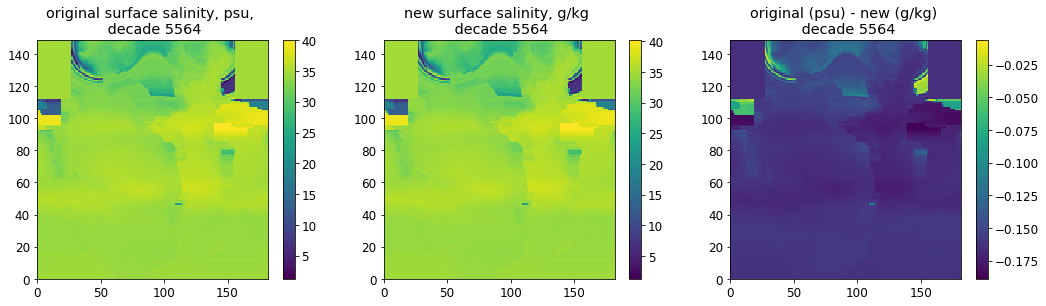

In [150]:
decs = ['5564','6574','7584','8594','95A4','A5B7']

dec = decs[0]
salt = xr.open_dataset(f'{tdir_regrid}woa18_{dec}_s00_01_regridORCA.nc', decode_times = False)
salt['s_an_gkg'] = salt.s_an.copy(deep = True)
salt['s_an_gkg'].values = salt['s_an'].values * 35.16504/35.000
salt.s_an_gkg.attrs['long_name'] = 'absolute salinity (g/kg)'
salt.attrs['description'] = 'made from original in /gpfs/home/mep22dku/scratch/WOA_regrid_TS, s_an_gkg is s_an corrected by the psu to absolute salinity correction'


fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(16*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(salt.s_an[0,0,:,:])
plt.colorbar(w, ax = axs[0])
axs[0].set_title(f'original surface salinity, psu, \n decade {dec}')

w = axs[1].pcolormesh(salt.s_an_gkg[0,0,:,:])
plt.colorbar(w, ax = axs[1])
axs[1].set_title(f'new surface salinity, g/kg \n decade {dec}')

w = axs[2].pcolormesh(salt.s_an[0,0,:,:]-salt.s_an_gkg[0,0,:,:])
plt.colorbar(w, ax = axs[2])
axs[2].set_title(f'original (psu) - new (g/kg) \n decade {dec}')

saving new salt file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_5564_s00_01_regridORCA_unitconv.nc
min difference  (psu - g/kg) salinity in 5564: -0.194174233501748
max difference (psu - g/kg) salinity in 5564: -0.00583711499796391
saving new salt file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_6574_s00_01_regridORCA_unitconv.nc
min difference  (psu - g/kg) salinity in 6574: -0.1941997036762757
max difference (psu - g/kg) salinity in 6574: -0.0028152440257869227
saving new salt file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_7584_s00_01_regridORCA_unitconv.nc
min difference  (psu - g/kg) salinity in 7584: -0.19400025928803188
max difference (psu - g/kg) salinity in 7584: -0.0063027405210507315
saving new salt file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_8594_s00_01_regridORCA_unitconv.nc
min difference  (psu - g/kg) salinity in 8594: -0.19417993521151544
max difference (psu - g/kg) salinity in 8594: -0.0032876629913510813
saving new salt file in /

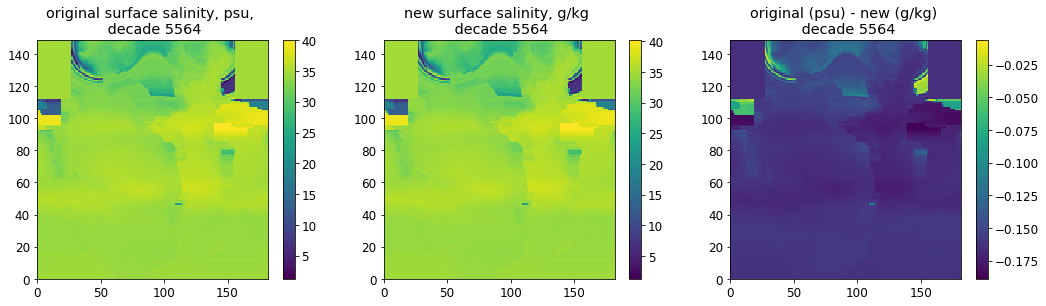

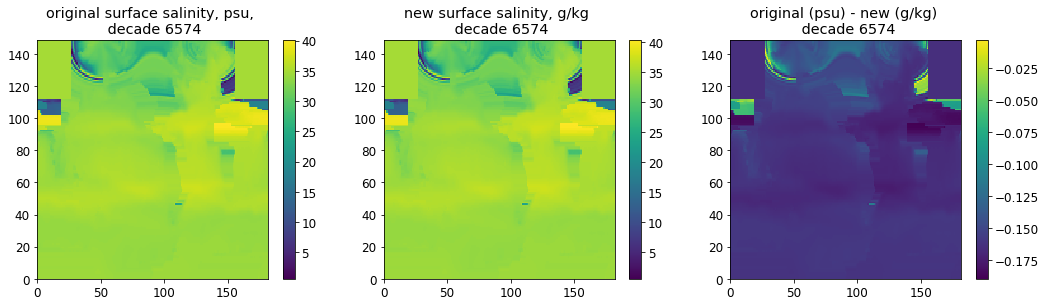

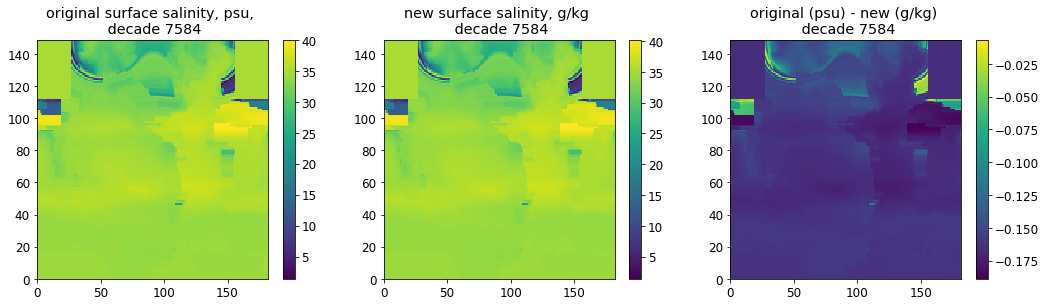

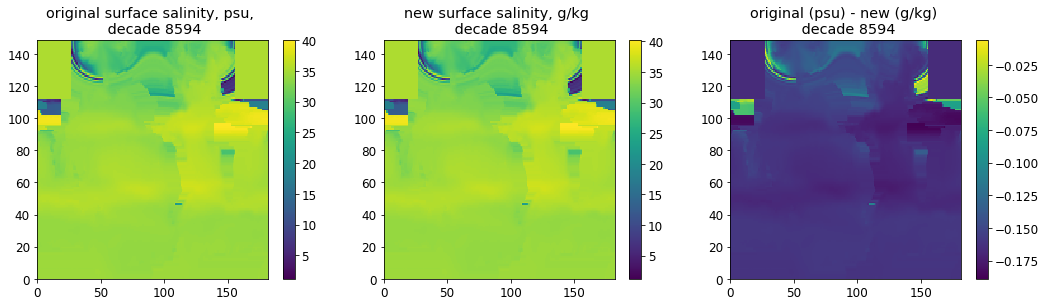

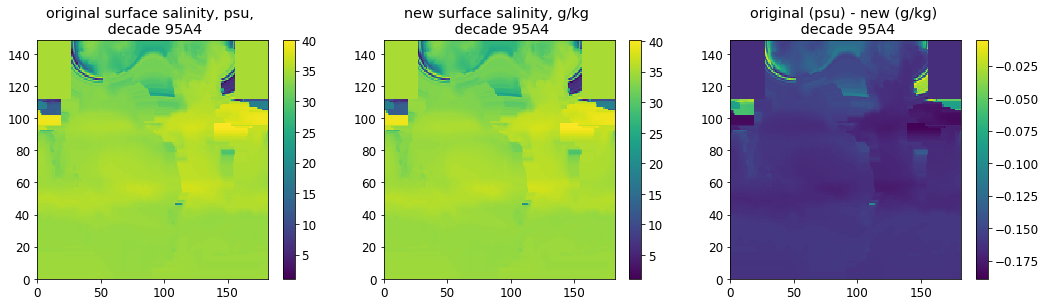

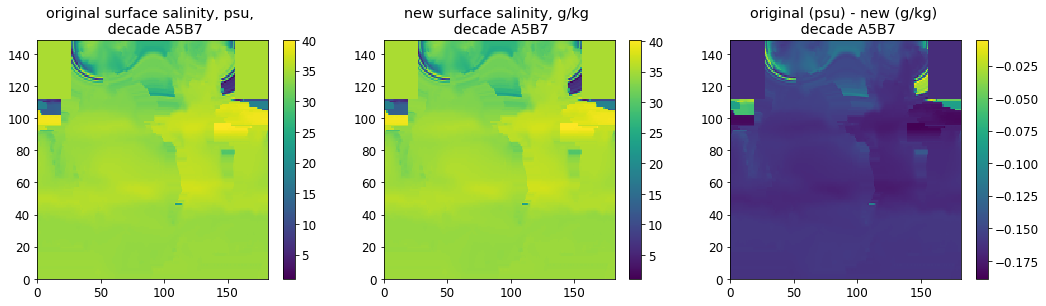

In [151]:
regrid_with_adj = '/gpfs/home/mep22dku/scratch/WOA_regrid_TS/'
decs = ['5564','6574','7584','8594','95A4','A5B7']

for i in range(0,6):
    dec = decs[i]
    salt = xr.open_dataset(f'{tdir_regrid}woa18_{dec}_s00_01_regridORCA.nc', decode_times = False)
    salt['s_an_gkg'] = salt.s_an.copy(deep = True)
    salt['s_an_gkg'].values = salt['s_an'].values * 35.16504/35.000
    salt.s_an_gkg.attrs['long_name'] = 'absolute salinity (g/kg)'
    salt.attrs['description'] = 'made from original in /gpfs/home/mep22dku/scratch/WOA_regrid_TS, s_an_gkg is s_an converted from psu to Abs Sal by the correction 35.16504/35.000'
    nam_to_save = f'{regrid_with_adj}/woa18_{dec}_s00_01_regridORCA_unitconv.nc'
    print(f'saving new salt file in {nam_to_save}')
    tdiff =   salt['s_an'].values - salt['s_an_gkg'].values 
    print(f'min difference  (psu - g/kg) salinity in {dec}: {np.nanmin(tdiff)}')
    print(f'max difference (psu - g/kg) salinity in {dec}: {np.nanmax(tdiff)}')
    salt.to_netcdf(nam_to_save)
    
    fact = 1.1
    fig, axs = plt.subplots(1,3, figsize=(16*fact, 4*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    w = axs[0].pcolormesh(salt.s_an[0,0,:,:])
    plt.colorbar(w, ax = axs[0])
    axs[0].set_title(f'original surface salinity, psu, \n decade {dec}')

    w = axs[1].pcolormesh(salt.s_an_gkg[0,0,:,:])
    plt.colorbar(w, ax = axs[1])
    axs[1].set_title(f'new surface salinity, g/kg \n decade {dec}')

    w = axs[2].pcolormesh(salt.s_an[0,0,:,:]-salt.s_an_gkg[0,0,:,:])
    plt.colorbar(w, ax = axs[2])
    axs[2].set_title(f'original (psu) - new (g/kg) \n decade {dec}')
    
    
    

## temperature adjustment code

- get in-situ T
- get absolute salinity, calculated above
- get a broadcasted depth array

I then save a new file to `/gpfs/home/mep22dku/scratch/WOA_regrid_TS` with the suffix `unitconv`.

saving new temp file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_5564_t00_01_regridORCA_unitconv.nc
min difference (cons T - in_situ T )  in 5564: -0.7164401537947196
max difference (cons T - in_situ T ) in 5564: 1.1776872822904885
mean difference (cons T - in_situ T ) in 5564: -0.08986157638256738
saving new temp file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_6574_t00_01_regridORCA_unitconv.nc
min difference (cons T - in_situ T )  in 6574: -0.7165622295262111
max difference (cons T - in_situ T ) in 6574: 1.1570875231917945
mean difference (cons T - in_situ T ) in 6574: -0.08978206813024366
saving new temp file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_7584_t00_01_regridORCA_unitconv.nc
min difference (cons T - in_situ T )  in 7584: -0.7180361575446188
max difference (cons T - in_situ T ) in 7584: 1.1367342473192181
mean difference (cons T - in_situ T ) in 7584: -0.08987723930119547
saving new temp file in /gpfs/home/mep22dku/scratch/WOA_regrid_TS//woa18_859

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 47880619137152:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


PermissionError: [Errno 13] Permission denied: b'/gpfs/home/mep22dku/scratch/WOA_regrid_TS/woa18_A5B7_t00_01_regridORCA_unitconv.nc'

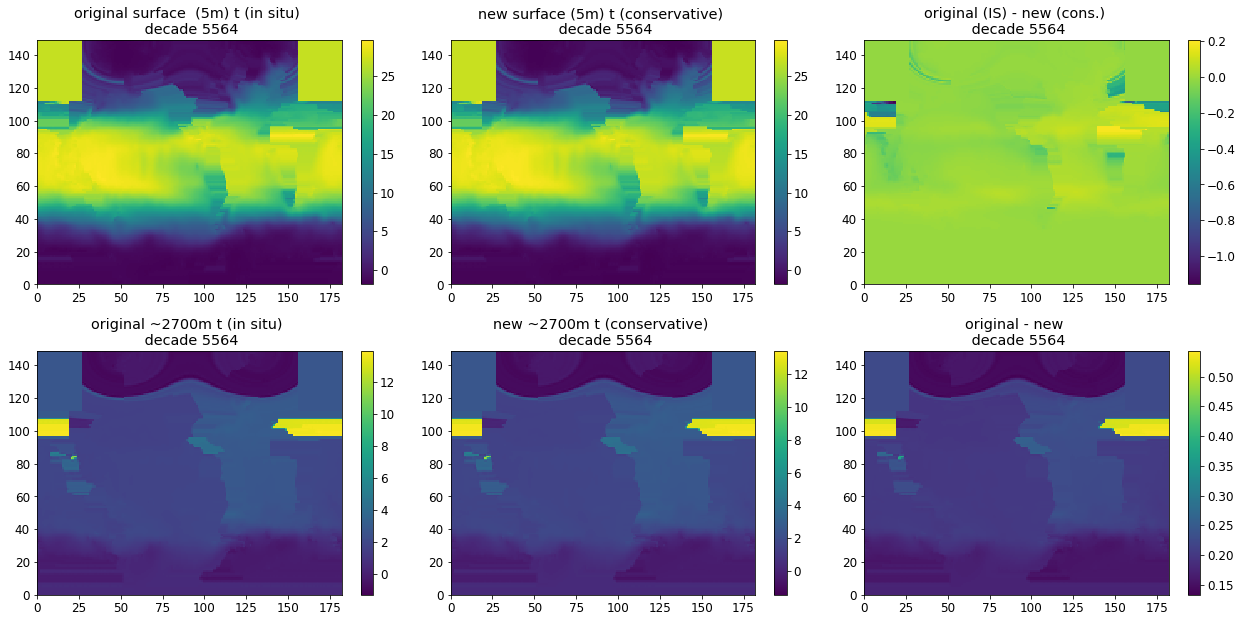

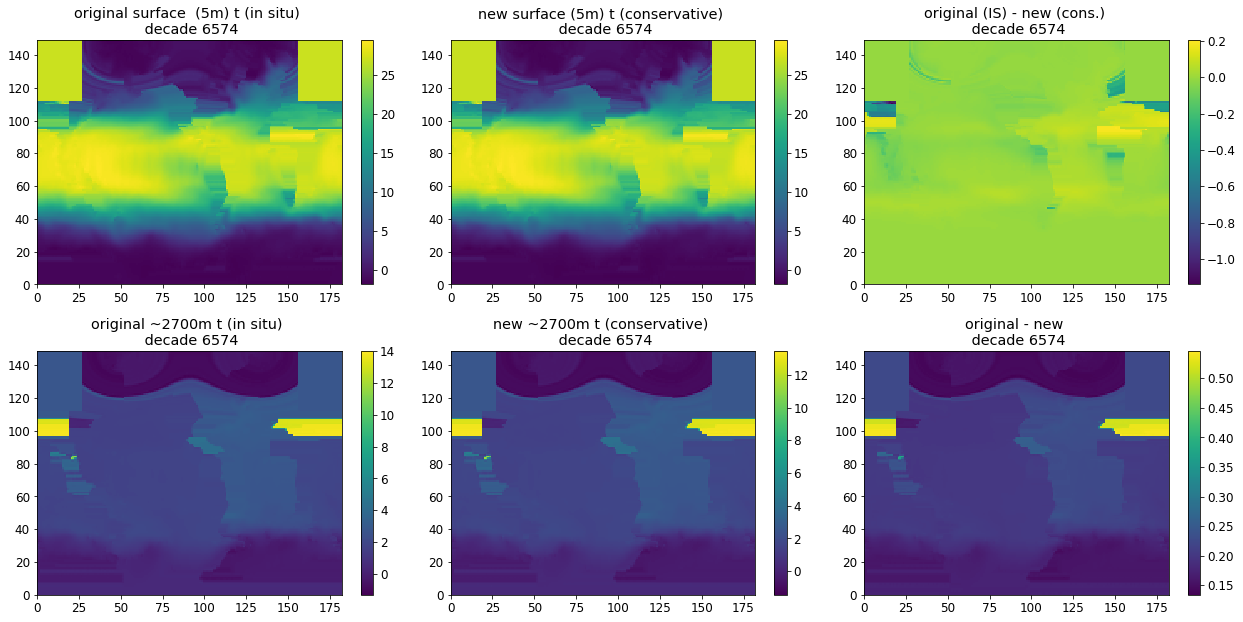

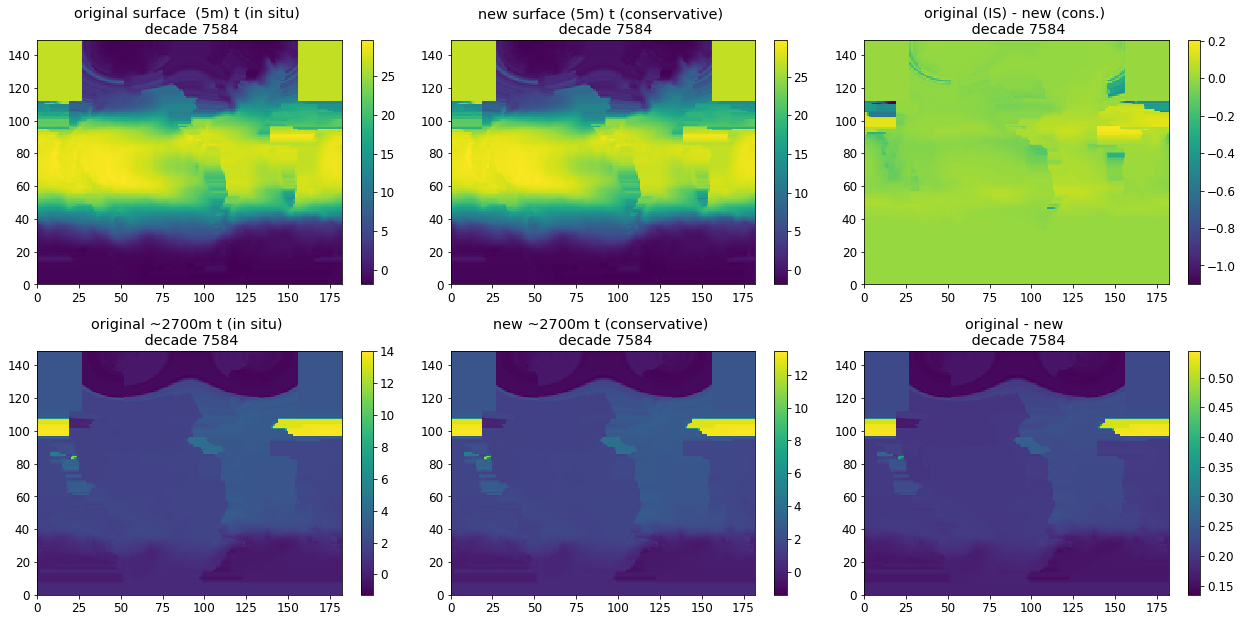

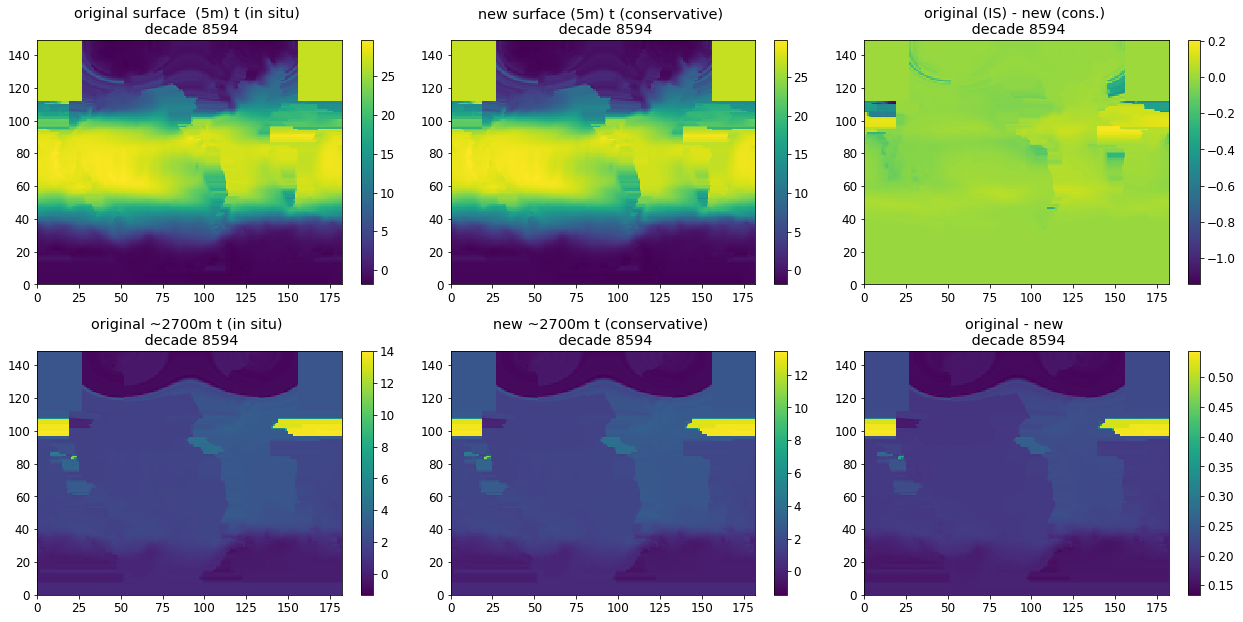

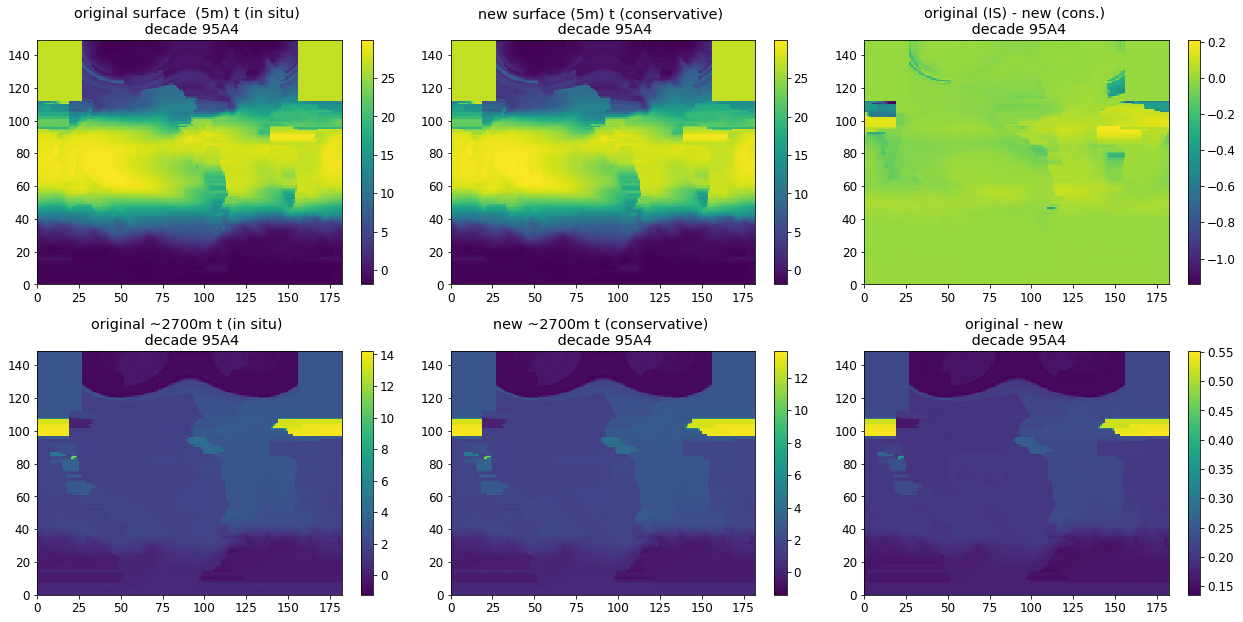

In [152]:
decs = ['5564','6574','7584','8594','95A4','A5B7']

for i in range(0,6):
    dec = decs[i]
    salt = xr.open_dataset(f'{regrid_with_adj}woa18_{dec}_s00_01_regridORCA_unitconv.nc', decode_times = False)
    temp = xr.open_dataset(f'{tdir_regrid}woa18_{dec}_t00_01_regridORCA.nc', decode_times = False)
    depths = np.zeros([1,31,149,182])
    #broadcasted depths array:
    for i in range(0,149):
        for j in range(0,182):
            depths[0,:,i,j] = temp['nav_lev'][:].values


    absS = salt['s_an_gkg'].values
    insituT = temp['t_an'].values
    pres = depths
    consT = gsw.CT_from_t(absS,insituT,pres)

    temp['t_CT'] = temp.t_an.copy(deep = True)
    temp['t_CT'].values = consT
    temp.t_CT.attrs['long_name'] = 'conservative T (deg C)'
    temp.attrs['description'] = 'made from original in /gpfs/home/mep22dku/scratch/WOA_regrid_TS, t_CT is t_an converted from in-situ to conservative using gsw.CT_from_t'
    nam_to_save = f'{regrid_with_adj}/woa18_{dec}_t00_01_regridORCA_unitconv.nc'
    print(f'saving new temp file in {nam_to_save}')
    tdiff =  temp['t_CT'].values -  temp['t_an'].values
    print(f'min difference (cons T - in_situ T )  in {dec}: {np.nanmin(tdiff)}')
    print(f'max difference (cons T - in_situ T ) in {dec}: {np.nanmax(tdiff)}')
    print(f'mean difference (cons T - in_situ T ) in {dec}: {np.nanmean(tdiff)}')
    temp.to_netcdf(nam_to_save)

    fact = 1.1
    fig, axs = plt.subplots(2,3, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    w = axs[0].pcolormesh(temp.t_an[0,0,:,:])
    plt.colorbar(w, ax = axs[0])
    axs[0].set_title(f'original surface  (5m) t (in situ) \n decade {dec}')

    w = axs[1].pcolormesh(temp.t_CT[0,0,:,:])
    plt.colorbar(w, ax = axs[1])
    axs[1].set_title(f'new surface (5m) t (conservative) \n decade {dec}')

    w = axs[2].pcolormesh(temp.t_an[0,0,:,:]-temp.t_CT[0,0,:,:])
    plt.colorbar(w, ax = axs[2])
    axs[2].set_title(f'original (IS) - new (cons.) \n decade {dec}')

    w = axs[3].pcolormesh(temp.t_an[0,25,:,:])
    plt.colorbar(w, ax = axs[3])
    axs[3].set_title(f'original ~2700m t (in situ) \n decade {dec}')

    w = axs[4].pcolormesh(temp.t_CT[0,25,:,:])
    plt.colorbar(w, ax = axs[4])
    axs[4].set_title(f'new ~2700m t (conservative) \n decade {dec}')

    w = axs[5].pcolormesh(temp.t_an[0,25,:,:]-temp.t_CT[0,25,:,:])
    plt.colorbar(w, ax = axs[5])
    axs[5].set_title(f'original - new \n decade {dec}')
    plt.tight_layout()
